In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize

In [12]:
import json
import glob
import os

In [13]:

jsonl_dir = 'anonymized-files-wisd/'
df_list = []
for file_name in glob.glob(os.path.join(jsonl_dir, '*.jsonl')):
    file_date = os.path.basename(file_name)[:8]
    file = os.path.basename(file_name)[9:13]
    with open(file_name, 'r') as f:
        data = [json.loads(line) for line in f.readlines()]
        df = pd.DataFrame(data)
    df['date'] = file_date
    df['filename'] = file
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)


In [14]:
combined_df.to_csv('combined_df')

In [19]:
# Summary Acts 
def extract_columns_summary_acts(row):
    
    return pd.Series({
        'pitch_eventId': row['pitch']['eventId'],
        'pitch_result': row['pitch']['result'],
        'pitch_type': row['pitch']['type'],
        'pitch_action': row['pitch']['action'],
        'pitch_speed_mph': row['pitch']['speed']['mph'],
        'pitch_spin_rpm': row['pitch']['spin']['rpm'],
        'hit_eventId': row['hit']['eventId'],
        'hit_speed_mph': row['hit']['speed']['mph'],
        'hit_spin_rpm': row['hit']['spin']['rpm'],
        'hit_stroke_type': row['stroke']['type'],
        'hit_stroke_attempt': row['stroke']['attempt'],
        
        
    })


summary_acts_df = combined_df['summary_acts'].apply(extract_columns_summary_acts)
summary_acts_df['pitch_type'] = summary_acts_df['pitch_type'].astype(str)
summary_acts_df['hit_eventId'] = summary_acts_df['hit_eventId'].astype(str)
summary_acts_df.to_csv('summary_acts.csv')


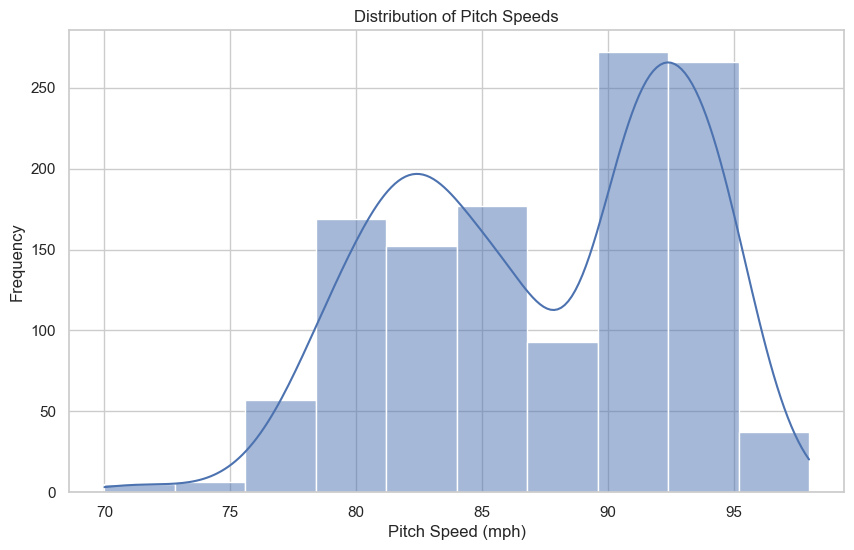

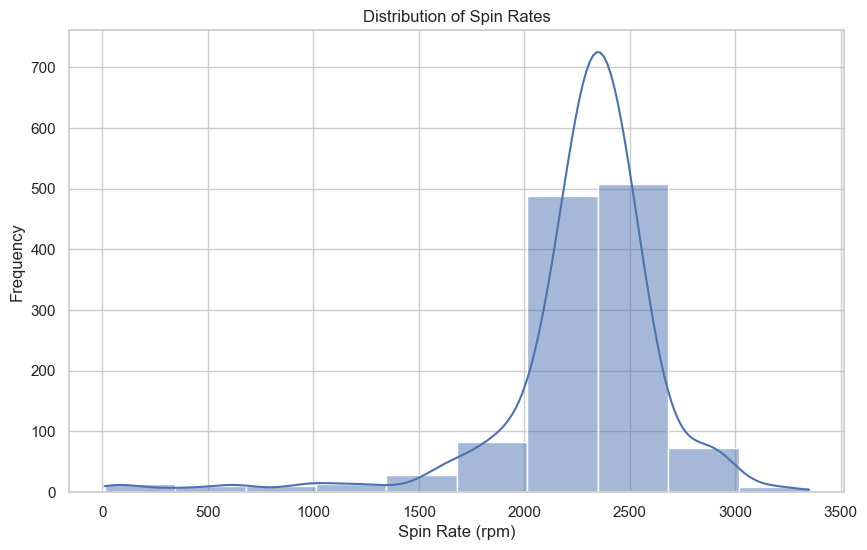

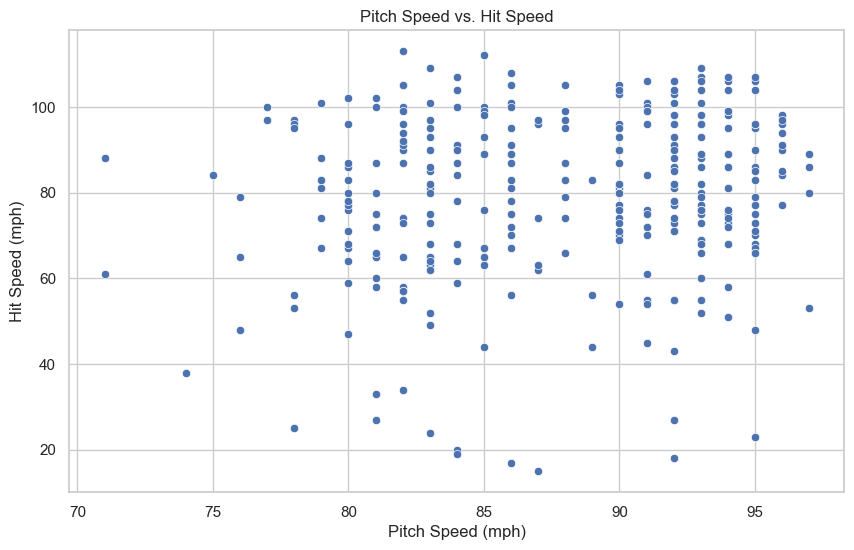

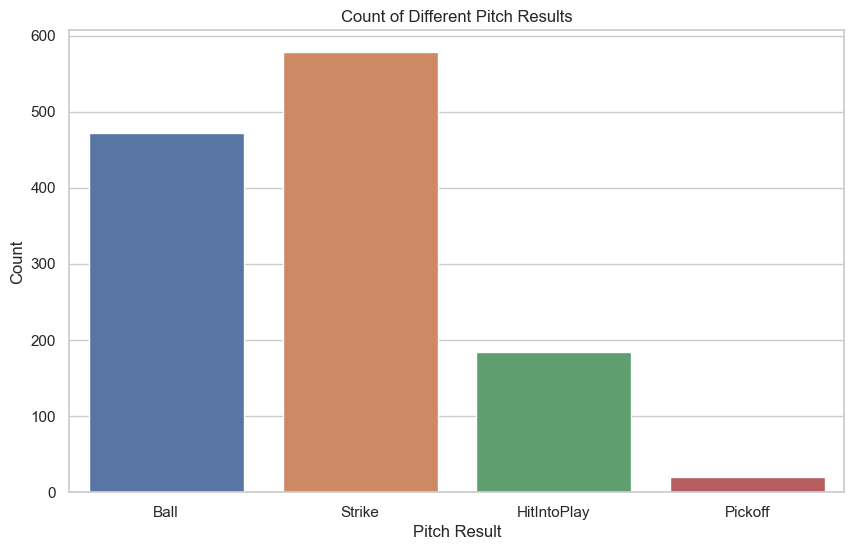

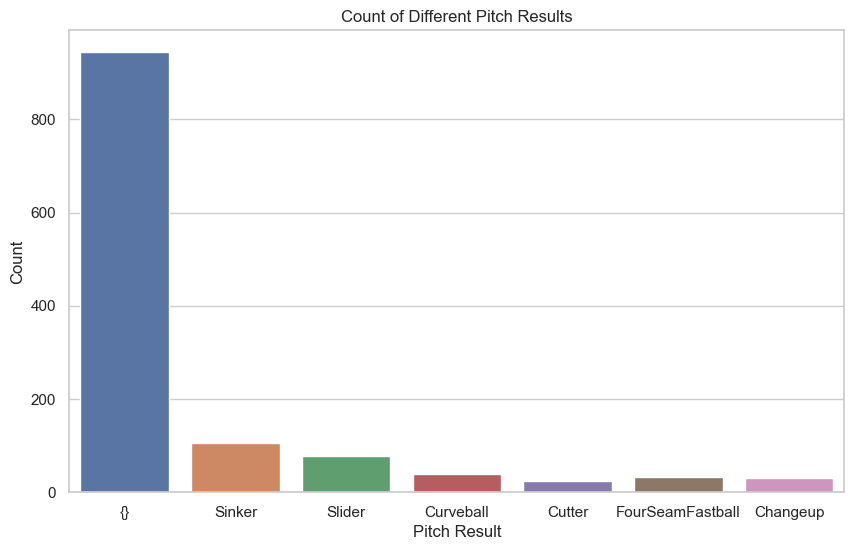

In [20]:
sns.set(style="whitegrid")

# Plot the distribution of pitch speeds
plt.figure(figsize=(10, 6))
sns.histplot(summary_acts_df['pitch_speed_mph'], kde=True, bins=10)
plt.title('Distribution of Pitch Speeds')
plt.xlabel('Pitch Speed (mph)')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of spin rates
plt.figure(figsize=(10, 6))
sns.histplot(summary_acts_df['pitch_spin_rpm'], kde=True, bins=10)
plt.title('Distribution of Spin Rates')
plt.xlabel('Spin Rate (rpm)')
plt.ylabel('Frequency')
plt.show()

# Scatter plot comparing pitch speeds and hit speeds
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pitch_speed_mph', y='hit_speed_mph', data=summary_acts_df)
plt.title('Pitch Speed vs. Hit Speed')
plt.xlabel('Pitch Speed (mph)')
plt.ylabel('Hit Speed (mph)')
plt.show()

# Count plot of different pitch results
plt.figure(figsize=(10, 6))
sns.countplot(x='pitch_result', data=summary_acts_df)
plt.title('Count of Different Pitch Results')
plt.xlabel('Pitch Result')
plt.ylabel('Count')
plt.show()

# Count plot of different pitch types
plt.figure(figsize=(10, 6))
sns.countplot(x='pitch_type', data=summary_acts_df)
plt.title('Count of Different Pitch Results')
plt.xlabel('Pitch Result')
plt.ylabel('Count')
plt.show()

In [22]:
def extract_columns_summary_score(row):
    summary_acts = row['summary_acts']
    summary_score = row['summary_score']
    file_name= row['filename']
    date = row['date']
    return pd.Series({
        'pitch_eventId': summary_acts['pitch']['eventId'],
        'runs_game_team1': summary_score['runs']['game']['team1'],
        'runs_game_team2': summary_score['runs']['game']['team2'],
        'runs_innings_team1': summary_score['runs']['innings'][0]['team1'],
        'runs_innings_team2': summary_score['runs']['innings'][0]['team2'],
        'runs_play': summary_score['runs']['play'],
        'outs_inning': summary_score['outs']['inning'],
        'outs_play': summary_score['outs']['play'],
        'balls_plateAppearance': summary_score['count']['balls']['plateAppearance'],
        'balls_play': summary_score['count']['balls']['play'],
        'strikes_plateAppearance': summary_score['count']['strikes']['plateAppearance'],
        'strikes_play': summary_score['count']['strikes']['play'],
        'date':date,
        'file_name': file_name
    })

summary_score_df = combined_df.apply(extract_columns_summary_score, axis=1)
summary_score_df.to_csv('summary_score.csv')

In [23]:
combined_df['events'] = combined_df['events'].apply(lambda x: x if x else None)
normalized_df = json_normalize(combined_df['events'].dropna().explode())
normalized_df.to_csv('events.csv')

In [24]:
def extract_columns_sample(row):
    summary_acts = row['summary_acts']
    sample_ball = row['samples_ball']
    sample_bat = row['samples_bat']
    return pd.Series({
        'pitch_eventId': summary_acts['pitch']['eventId'],
        'event': sample_bat[0]['event'],
        'total_ball':sample_ball,
        'total_bat': sample_bat
        
         })

sample_df = combined_df.apply(extract_columns_sample, axis=1)
sample_df.to_csv('sample.csv')

In [ ]:
bats = sample_df[sample_df['event'] != 'No']

df = pd.DataFrame(bats)


result_df = pd.DataFrame(columns=['pitch_eventId', 'event', 'time', 'head', 'handle'])

for idx, row in df.iterrows():
    total_bat_df = pd.DataFrame(row['total_bat'])
    hit_data = total_bat_df[total_bat_df['event'] == 'Nearest']
    if not hit_data.empty:
        hit_time = hit_data['time'].values[0]
        hit_head = hit_data['head'].values[0]
        hit_handle = hit_data['handle'].values[0]
        
        result_df = result_df.append({
            
            'pitch_eventId': row['pitch_eventId'],
            'event': 'Hit',
            'time': hit_time,
            'head': hit_head,
            'handle': hit_handle
        }, ignore_index=True)


In [ ]:
bats = sample_df[sample_df['event'] != 'No']

df = pd.DataFrame(bats)

result_df = pd.DataFrame(columns=['pitch_eventId', 'event', 'time', 'head', 'handle'])

for idx, row in df.iterrows():

    total_bat_df = pd.DataFrame(row['total_bat'])
    
    hit_data = total_bat_df[total_bat_df['event'] == 'Hit']
 
    if not hit_data.empty:
        hit_time = hit_data['time'].values[0]
        hit_head = hit_data['head'].values[0]
        hit_handle = hit_data['handle'].values[0]
        
        result_df = result_df.append({
            
            'pitch_eventId': row['pitch_eventId'],
            'event': 'Hit',
            'time': hit_time,
            'head': hit_head,
            'handle': hit_handle
        }, ignore_index=True)


In [ ]:
result_df = result_df.loc[result_df['time'] >= 0.2]

In [ ]:
bat_data = pd.DataFrame(result_df)

ball_data = pd.DataFrame(sample_df)


def find_two_points(time, total_ball):
    for i in range(len(total_ball) - 1):
        if total_ball[i]['time'] <= time <= total_ball[i + 1]['time']:
            return total_ball[i], total_ball[i + 1]
    return None, None

bat_data['ball_points'] = bat_data.apply(lambda row: find_two_points(row['time'], ball_data[ball_data['pitch_eventId'] == row['pitch_eventId']]['total_ball'].values[0]), axis=1)

(bat_data.to_csv('bat.csv'))